In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.utils import resample
import numpy as np

In [2]:
# Read the CSV file
df = pd.read_csv('diagnosed_cbc_data_v4.csv')

# Display the first few rows of the dataframe
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
    WBC  LYMp  NEUTp  LYMn  NEUTn   RBC  HGB    HCT   MCV   MCH  MCHC    PLT  \
0  10.0  43.2   50.1   4.3    5.0  2.77  7.3   24.2  87.7  26.3  30.1  189.0   
1  10.0  42.4   52.3   4.2    5.3  2.84  7.3   25.0  88.2  25.7  20.2  180.0   
2   7.2  30.7   60.7   2.2    4.4  3.97  9.0   30.5  77.0  22.6  29.5  148.0   
3   6.0  30.2   63.5   1.8    3.8  4.22  3.8   32.8  77.9  23.2  29.8  143.0   
4   4.2  39.1   53.7   1.6    2.3  3.93  0.4  316.0  80.6  23.9  29.7  236.0   

    PDW   PCT                      Diagnosis  
0  12.5  0.17  Normocytic hypochromic anemia  
1  12.5  0.16  Normocytic hypochromic anemia  
2  14.3  0.14         Iron deficiency anemia  
3  11.3  0.12         Iron deficiency anemia  
4  12.8  0.22  Normocytic hypochromic anemia  


In [3]:
# Data Analysis

# 1. Identify unique diagnoses and their counts
diagnosis_counts = df['Diagnosis'].value_counts()
print("\nDiagnosis counts:")
diagnosis_counts


Diagnosis counts:


Diagnosis
Healthy                           336
Normocytic hypochromic anemia     279
Normocytic normochromic anemia    269
Iron deficiency anemia            189
Thrombocytopenia                   73
Other microcytic anemia            59
Leukemia                           47
Macrocytic anemia                  18
Leukemia with thrombocytopenia     11
Name: count, dtype: int64

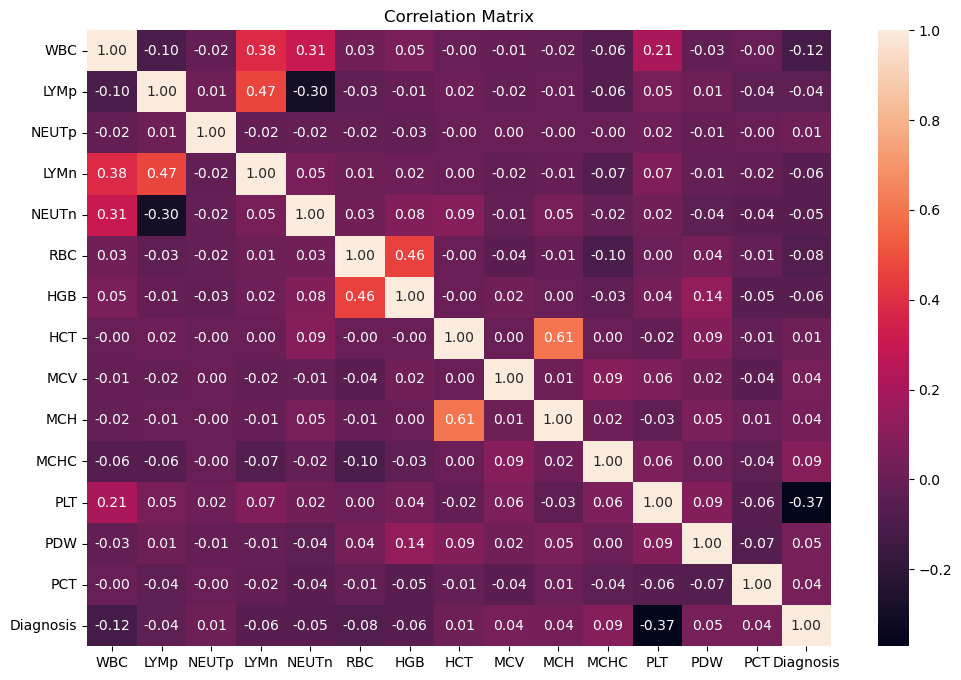

In [4]:
# 2. Analyze correlation between parameters and diagnosis
# Encode the diagnosis column for correlation analysis
df_encoded = df.copy()
df_encoded['Diagnosis'] = df_encoded['Diagnosis'].astype('category').cat.codes
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Identify highly correlated features with Diagnosis
correlation_with_diagnosis = correlation_matrix['Diagnosis'].sort_values(ascending=False)
print("\nCorrelation of features with Diagnosis:")
correlation_with_diagnosis


Correlation of features with Diagnosis:


Diagnosis    1.000000
MCHC         0.094572
PDW          0.045841
MCV          0.042692
PCT          0.042501
MCH          0.036039
HCT          0.013447
NEUTp        0.011242
LYMp        -0.036034
NEUTn       -0.054911
LYMn        -0.058303
HGB         -0.059197
RBC         -0.078917
WBC         -0.122703
PLT         -0.371444
Name: Diagnosis, dtype: float64

In [6]:
# Data Preprocessing
# Encode categorical Diagnosis column
df['Diagnosis'] = df['Diagnosis'].astype('category').cat.codes

# Split the data into features and target
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

# Split the data into 80% training and 20% validation
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_val_scaled = scaler.transform(X_val)

# Handle class imbalance by oversampling the training set
df_train_full = pd.concat([X_train_full, y_train_full], axis=1)
max_size = df_train_full['Diagnosis'].value_counts().max()

# Resample each class to match the size of the largest class
lst = [df_train_full]
for class_index, group in df_train_full.groupby('Diagnosis'):
    lst.append(group.sample(max_size-len(group), replace=True))
df_balanced = pd.concat(lst)

X_balanced = df_balanced.drop('Diagnosis', axis=1)
y_balanced = df_balanced['Diagnosis']

# Standardize the balanced features
X_balanced_scaled = scaler.fit_transform(X_balanced)

# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
all_y_test = []
all_y_pred = []

# Initialize a variable to store the fitted model for feature importance visualization
final_model = None

for train_index, test_index in kfold.split(X_balanced_scaled):
    X_train, X_test = X_balanced_scaled[train_index], X_balanced_scaled[test_index]
    y_train, y_test = y_balanced.iloc[train_index], y_balanced.iloc[test_index]

    # Support Vector Machine Classifier
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)

    # Store the results
    accuracy = np.mean(y_pred == y_test)
    accuracy_scores.append(accuracy)
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

    # Store the final model for feature importance visualization
    final_model = model

In [7]:
# Overall performance
print("\nK-Fold Cross-Validation Accuracy Scores:")
print(accuracy_scores)
print("\nMean Accuracy: ", np.mean(accuracy_scores))


K-Fold Cross-Validation Accuracy Scores:
[0.9154639175257732, 0.8822314049586777, 0.9235537190082644, 0.8801652892561983, 0.9028925619834711]

Mean Accuracy:  0.900861378546477


In [8]:
# Classification report
print("\nClassification Report:")
print(classification_report(all_y_test, all_y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       269
           1       0.86      0.86      0.86       269
           2       0.93      0.95      0.94       269
           3       0.95      1.00      0.97       269
           4       0.94      1.00      0.97       269
           5       0.83      0.72      0.77       269
           6       0.89      0.83      0.86       269
           7       0.87      0.88      0.88       269
           8       0.89      0.99      0.94       269

    accuracy                           0.90      2421
   macro avg       0.90      0.90      0.90      2421
weighted avg       0.90      0.90      0.90      2421



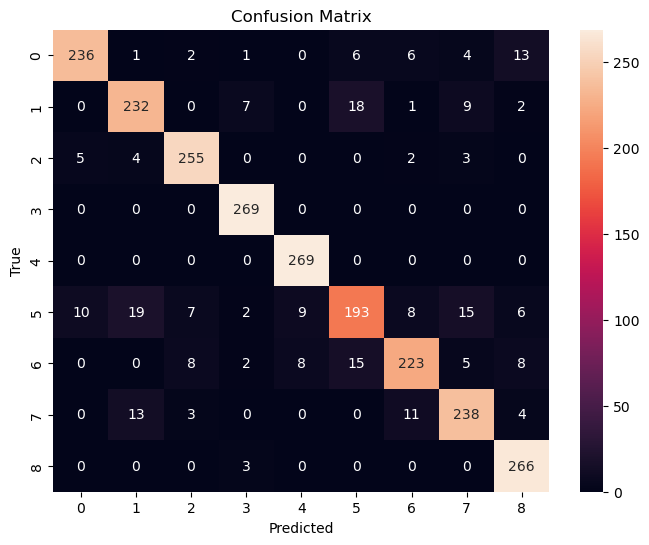

In [9]:
# Confusion matrix
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Feature ranking:
1. feature 6 (3.3715473457451886) - HGB
2. feature 8 (2.949684763195523) - MCV
3. feature 10 (1.0355979441436247) - MCHC
4. feature 9 (0.8449256890318597) - MCH
5. feature 13 (0.7301171540669893) - PCT
6. feature 0 (0.583141350263487) - WBC
7. feature 2 (0.5422840894508074) - NEUTp
8. feature 5 (0.48816523033716086) - RBC
9. feature 3 (0.23485312921041235) - LYMn
10. feature 4 (0.16925338530886203) - NEUTn
11. feature 12 (0.1027807605814326) - PDW
12. feature 11 (0.06781505052659659) - PLT
13. feature 1 (0.05780789905199635) - LYMp
14. feature 7 (0.05414012468813856) - HCT


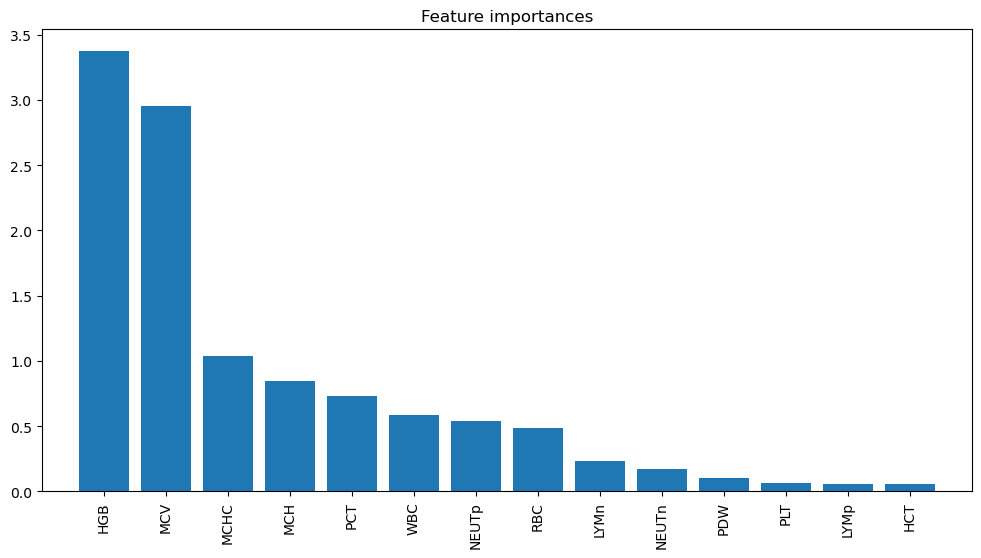

In [10]:
# Feature importance for SVM
# Note: SVM does not provide feature importances directly. However, for a linear kernel, we can use the coefficients.
coef = final_model.coef_[0]  # Take the coefficients of the first class (binary relevance)
coef = np.abs(coef)  # Take absolute value of coefficients

# Get the feature importances from the coefficients
indices = np.argsort(coef)[::-1]

# Print the feature ranking
print("\nFeature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({coef[indices[f]]}) - {X.columns[indices[f]]}")

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), coef[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [11]:
# Evaluate the model on the validation set
model.fit(X_balanced_scaled, y_balanced)
y_val_pred = model.predict(X_val_scaled)

# Validation performance
print("\nValidation Set Accuracy: ", np.mean(y_val_pred == y_val))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))


Validation Set Accuracy:  0.6964980544747081

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        67
           1       0.80      0.87      0.84        38
           2       0.38      0.67      0.48         9
           3       0.22      1.00      0.36         2
           4       0.36      1.00      0.53         4
           5       1.00      0.57      0.73        56
           6       0.91      0.56      0.69        54
           7       0.53      0.67      0.59        12
           8       0.39      0.87      0.54        15

    accuracy                           0.70       257
   macro avg       0.60      0.77      0.61       257
weighted avg       0.79      0.70      0.71       257



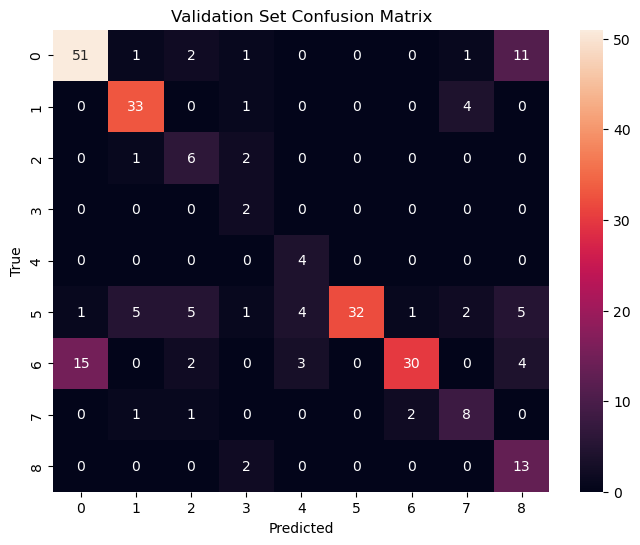

In [12]:
# Validation set confusion matrix
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d')
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()